In [1]:
import pandas as pd 
from IPython.display import display
import textwrap
import json 
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models import LdaModel
import matplotlib.pyplot as plt

from scripts.preprocessing.assign_lda_topics import assign_topics_

## Explanation

- input: df with lda-topic probabilities, lda model
- enables manual inspection of topic labels
- creates plots of yearly occurence of specified topics
- option to save specific topic dataset

### Import dataset and model

In [2]:
dataset_path = "data/parllaw/final.parquet"
corpus_path = "data/lda/corpus_final.c"

df = pd.read_parquet(dataset_path)
corpus = corpora.MmCorpus(corpus_path)

In [3]:
def load_model(n_topics=50, n_passes=5):
    model_path = f"data/lda/screens/{n_topics}_topics/{n_passes}/model.model"
    model = LdaModel.load(model_path)
    return model

### Print top k=5 words of every topic to inspect LDA composition

In [11]:
def print_topics(model, n_topics, k_words=5):
    '''
    print all n topics of the lda model 
    '''
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx}: {label}")

In [60]:
print_topics(model, n_topics)

Topic 0: market, development, service, sector, digital
Topic 1: woman, social, education, young, gender
Topic 2: agreement, trade, cooperation, development, economic
Topic 3: climate, ukraine, emission, russia, change
Topic 4: future, good, uk, today, want
Topic 5: want, know, say, government, today
Topic 6: worker, fund, company, globalization, market
Topic 7: turkey, security, conflict, resolution, peace
Topic 8: fishing, health, fishery, water, sea
Topic 9: law, rule, issue, colleague, debate
Topic 10: datum, information, protection, terrorism, security
Topic 11: money, think, want, commissioner, know
Topic 12: tax, regulation, proposal, council, directive
Topic 13: human, freedom, death, attack, world
Topic 14: product, food, regulation, agricultural, animal
Topic 15: child, convention, international, human, crime
Topic 16: energy, gas, price, renewable, efficiency
Topic 17: economic, investment, growth, crisis, social
Topic 18: border, refugee, migration, solidarity, asylum
Topic 

### Explore topics by their ID

In [44]:
# plotting parameters
party_block_colors = {
    'left': 'purple',
    'green': 'green',
    'social_democratic': 'red',
    'christian_conservative': 'black',
    'liberal': 'orange',
    'right_populist': 'blue'
}
election_years = [2014, 2019] #[1999, 2004, 2009, 2014, 2019, 2024]

In [6]:
def find_topic_id(keyword, model, n_topics=50, top_n=10):
    """
    returns the topic id containing the keyword in its top_n words.
    if the keyword appears in multiple topics, returns the list of topic ids and prints a warning.
    """
    matches = []
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics, num_words=top_n):
        words = [word for word, prob in topic]
        if keyword in words:
            matches.append(idx)
    if not matches:
        return None
    if len(matches) > 1:
        print(f"Warning: keyword '{keyword}' found in multiple topics: {matches}")
        return matches
    return matches[0]

In [ ]:
def plot_abs_numbers_over_time(topic_id, model, df=df):
    pass
    # TODO 

In [7]:
def explore_topic_id(topic_id, model, df, n_topics, top_n_terms=10, speech_number=10, prob_threshold=0.3, log_scale=True):
    '''
    Explore topic with id topic_id in LDA model and dataframe df.
    Prints top terms, number of speeches, top speeches, just passing speeches, and plots number and ratio of speeches per year and party block.
    Parameters:
    - topic_id: int, id of topic to explore
    - model: LdaModel, trained LDA model
    - df: pd.DataFrame, dataframe with speeches and topic probabilities
    - top_n_terms: int, number of top terms to print
    - speech_number: int, number of top and just passing speeches to print
    - prob_threshold: float, probability threshold to select speeches
    Returns:
    - df_selected_topic: pd.DataFrame, dataframe with speeches selected for the topic
    '''
    # define df_selected_topic
    df_selected_topic = df[df[f'topic_{topic_id}'] >= prob_threshold]

    # return first 10 words and their probabilities for topic of interest
    topic_terms = model.show_topic(topicid=topic_id, topn=top_n_terms)
    print(f"Topic {topic_id} terms:")
    for word, prob in topic_terms:
        print(f"  {word}: {prob:.4f}")
    # save first three words
    first_3_words = [word for word, prob in topic_terms[:3]]

    # number of speeches in topic
    n_speeches = df_selected_topic.shape[0]
    print(f"Number of speeches in topic {topic_id} ({first_3_words}) with prob >= {prob_threshold}): {n_speeches}")
    
    # return top speeches
    print(f"Top speeches for topic {topic_id} ({first_3_words}):\n")
    df_selected_topic_sorted_desc = df_selected_topic.sort_values(by=f"topic_{topic_id}", ascending=False)
    for i in range(speech_number):
        speech = df_selected_topic_sorted_desc.iloc[i]
        print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
        print(textwrap.fill(speech["translatedText"], width=80))
        print("\n" + "-"*80 + "\n")

    # return speeches just above threshold
    print(f"Just passing speeches for topic {topic_id} ({first_3_words}):\n")
    df_selected_topic_sorted = df_selected_topic.sort_values(by=f"topic_{topic_id}")
    for i in range(speech_number):
        speech = df_selected_topic_sorted.iloc[i]
        print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
        print(textwrap.fill(speech["translatedText"], width=80))
        print("\n" + "-"*80 + "\n")

    # plot 
    # plots: number and ratio of speeches per year and party block
    party_blocks = df_selected_topic['block'].unique()
    years = sorted(df_selected_topic['year'].unique())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    for party_block in party_blocks:
        counts_per_year = []
        normalized_counts_per_year = []
        for year in years:
            count = df_selected_topic[(df_selected_topic['block'] == party_block) & (df_selected_topic['year'] == year)].shape[0]
            counts_per_year.append(count)
            total_count = df[(df['block'] == party_block) & (df['year'] == year)].shape[0]
            normalized_count = count / total_count if total_count > 0 else 0
            normalized_counts_per_year.append(normalized_count)
        ax1.plot(years, counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
        if log_scale: 
            ax1.set_yscale("log")
        ax2.plot(years, normalized_counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
    for year in election_years:
        ax1.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
        ax2.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
    ax1.set_xticks(election_years)
    ax2.set_xticks(election_years)
    # add horizontal grid lines
    ax1.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
    ax2.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
    ax1.set_title(f"Number of speeches per year for topic {topic_id} ({first_3_words}) [{n_topics}]")
    ax1.set_ylabel("Number of speeches")
    ax1.legend()
    ax2.set_title(f"Ratio of speeches per year for topic {topic_id} ({first_3_words})")
    ax2.set_ylabel("Ratio of speeches")
    ax2.set_xlabel("Year")
    ax2.legend()
    plt.tight_layout()
    plt.show()    

    return df_selected_topic

In [8]:
def combined_ratio_plot(topic_id_list, model, df = df, prob_threshold=0.3):
    '''
    plots ratio of speeches per party over the years for each topic in topic_id_list
    Parameters:
    - topic_id_list: list of int, list of topic ids to plot
    - model: LdaModel, trained LDA model
    - df_topics: pd.DataFrame, dataframe with speeches and topic probabilities
    - prob_threshold: float, probability threshold to select speeches
    '''
    # plot ratio of speeches per party over the years for each topic in topic_id_list
    n_topics = len(topic_id_list)
    ncols = 2
    nrows = (n_topics + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows), sharex=True)
    
    # flatten axes to iterate easily (handles case nrows==1 or >1)
    axes = np.array(axes).reshape(-1)
    
    party_blocks = sorted(df['party_block'].unique())
    years = sorted(df['year'].unique())
    
    for ax, topic_id in zip(axes, topic_id_list):
        for party_block in party_blocks:
            normalized_counts_per_year = []
            for year in years:
                df_selected_topic = df[
                    (df[f'topic_{topic_id}'] >= prob_threshold) &
                    (df['party_block'] == party_block) &
                    (df['year'] == year)
                ]
                count = df_selected_topic.shape[0]
                total_count = df[
                    (df['party_block'] == party_block) &
                    (df['year'] == year)
                ].shape[0]
                normalized_count = count / total_count if total_count > 0 else 0
                normalized_counts_per_year.append(normalized_count)
            ax.plot(years, normalized_counts_per_year, label=party_block,
                    marker='o', color=party_block_colors.get(party_block, 'gray'))
            ax.set_xticks(range(election_years[0], election_years[-1]+1))
            ax.set_xticklabels([str(y) for y in election_years])
            # ensure ticks/labels are shown for every subplot (even when sharex=True)
            ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
            ax.xaxis.set_visible(True)
            for year in election_years:
                ax.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
            ax.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
            first_words = [word for word, prob in model.show_topic(topicid=topic_id, topn=4)]
            ax.set_title(f"Topic {topic_id} {first_words}", fontsize=12)
            idx = list(axes).index(ax)
            if idx % ncols == 0:
                ax.set_ylabel("Ratio of speeches")
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

    # turn off any unused subplots
    for ax in axes[len(topic_id_list):]:
        ax.axis('off')
    
    # place legend in the first subplot (upper left)
    if len(axes) > 0:
        axes[0].legend(loc='upper left', fontsize = 12)
    
    plt.suptitle(f"Ratio of speeches about {n_topics} selected topics over time", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [9]:
models = dict() 
dfs = dict() 

In [15]:
# for n_topics in [10, 20, 25, 30, 40, 50, 60, 80, 100]:

for n_topics in [30]: 
    for n_passes in [10]: 
        print("n Topics:", n_topics) 
        model = load_model(n_topics=n_topics, n_passes=5)
        migration_topics = find_topic_id("migration", model, n_topics)

        print_topics(model, n_topics)

        df_topic = assign_topics_(df, model, n_topics, corpus)
        
        if migration_topics is None: 
            print("No relevant topic!")
            continue
        if not isinstance(migration_topics, list): 
            migration_topics = [migration_topics]
        
        # for migration_topic in migration_topics: 
            # print("Relevant topic:", migration_topic)
            # explore_topic_id(migration_topic, model, df_topic, n_topics)

        models[(n_topics, n_passes)] = model 
        dfs[(n_topics, n_passes)] = df_topic

n Topics: 30
Topic 0: woman, gender, equality, man, violence
Topic 1: cultural, digital, technology, sector, industry
Topic 2: crime, reform, fight, accession, process
Topic 3: food, agricultural, product, farmer, sector
Topic 4: fishing, fishery, sea, fish, sustainable
Topic 5: agreement, trade, cooperation, economic, relation
Topic 6: energy, market, price, renewable, gas
Topic 7: safety, road, health, railway, accident
Topic 8: refugee, border, turkey, migration, migrant
Topic 9: fund, development, investment, budget, economic
Topic 10: health, product, animal, food, substance
Topic 11: government, election, juncker, institution, political
Topic 12: worker, fund, company, globalization, market
Topic 13: market, business, service, company, financial
Topic 14: terrorist, attack, israel, iraq, terrorism
Topic 15: regulation, proposal, council, favor, text
Topic 16: emission, climate, industry, reduce, green
Topic 17: ukraine, russia, security, russian, war
Topic 18: climate, global, ch

Assigning most probable topic to each speech: 100%|██████████| 236812/236812 [00:27<00:00, 8514.57it/s] 


Topic 8 terms:
  refugee: 0.0324
  border: 0.0234
  turkey: 0.0231
  migration: 0.0184
  migrant: 0.0142
  asylum: 0.0138
  crisis: 0.0107
  situation: 0.0073
  problem: 0.0071
  mediterranean: 0.0070
Number of speeches in topic 8 (['refugee', 'border', 'turkey']) with prob >= 0.3): 9743
Top speeches for topic 8 (['refugee', 'border', 'turkey']):

Speech 1 with topic probability 0.9897:
Madam President, Mr Commissioner, Mr Foreign Minister Bert Koenders, good to see
you again. I think we all know that the Dublin system has collapsed, and now
Schengen is next in line if we do not act. This situation is a direct result of
the lack of solidarity and of a common European approach to the refugee crisis.
It is due to the lack of efficient control of our European external borders and
the fact that too many Member States are failing to take their share of
refugees. While some count their asylum applications in tens of thousands,
others are counting them only in hundreds or even less. Member St

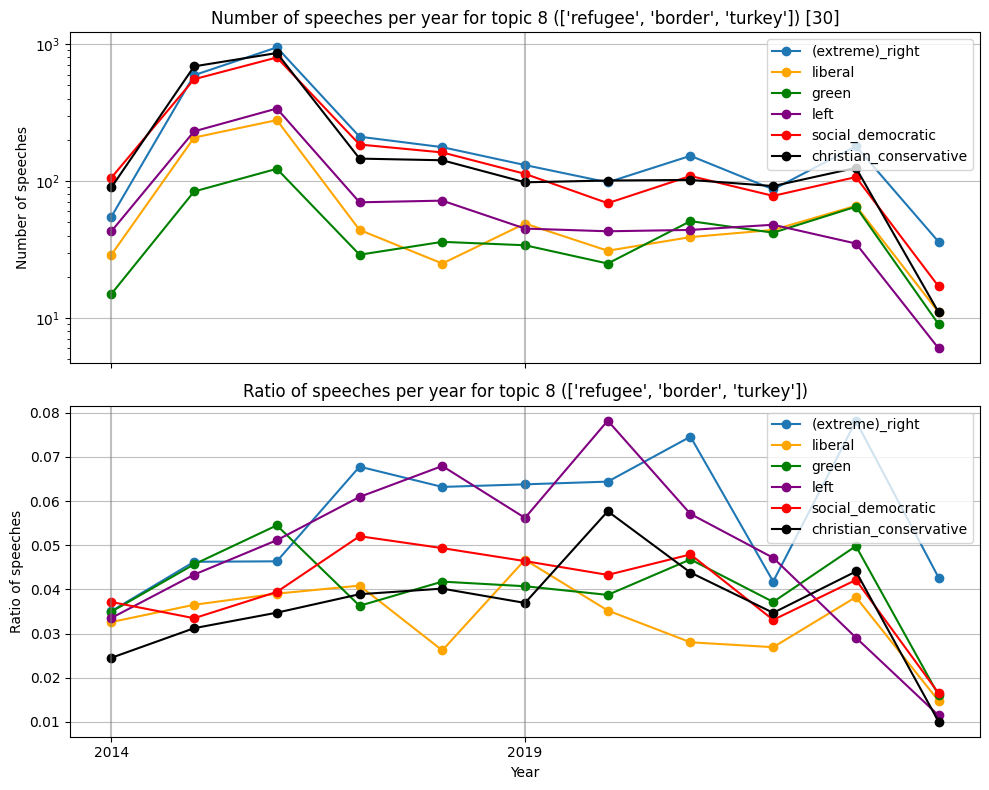

In [121]:
# n_topics = 40
n_topics = 30

model = models[n_topics]
df_topic = dfs[n_topics]

relevant_topics = find_topic_id("migration", model, n_topics)

if relevant_topics is None: 
    print("No relevant topic!")
else: 
    if not isinstance(relevant_topics, list): 
        relevant_topics = [relevant_topics]
    for relevant_topics in relevant_topics: 
        explore_topic_id(relevant_topics, model, df_topic, n_topics)

In [152]:
stats = json.load(open("data/lda/screens/comparison.json"))
stats = pd.DataFrame(stats) 

import matplotlib.pyplot as plt 


In [153]:
stats[stats["n_topics"] == 30]

,n_topics,n_passes,coherence,highest_prob,top_pos,n_relevant_topics
6,30,20,0.5508770641516492,0.03202843,2,1
7,30,10,0.5502067391355608,0.025598839,2,1
8,30,5,0.5573851577889363,0.01842598,3,1


In [127]:
stats.groupby("n_topics")

In [149]:
stats["coherence"] = stats["coherence"].astype(float)
stats["highest_prob"] = stats["highest_prob"].astype(float)

KeyError: 'n_topics'

In [133]:
stats = stats.groupby("n_topics").mean()

In [147]:
stats

,n_passes,coherence,highest_prob,top_pos,n_relevant_topics
n_topics,,,,,
10,5.0,0.472070,0.007199,8.0,1.0
20,5.0,0.534286,0.016546,2.0,1.0
25,7.5,0.554377,0.021750,2.5,1.0
30,7.5,0.553796,0.022012,2.5,1.0
40,7.5,0.563017,0.025353,2.0,1.0
50,7.5,0.560327,0.029128,1.5,1.0
60,7.5,0.550996,0.024583,2.0,2.0
80,7.5,0.526664,0.033428,1.5,1.0
100,7.5,0.522345,0.038523,1.0,1.0


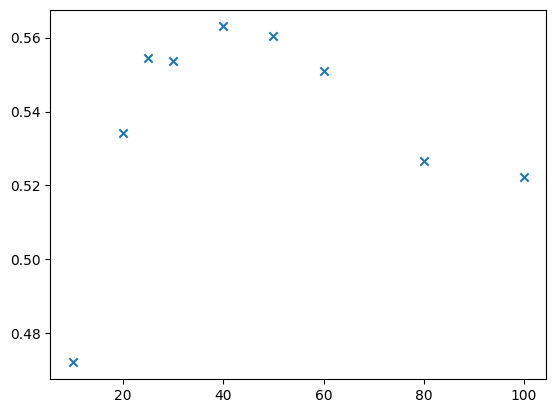

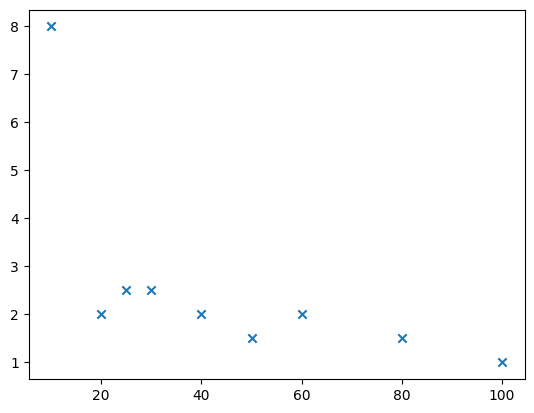

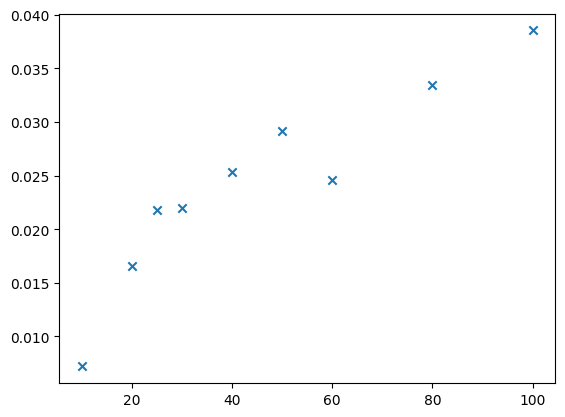

In [148]:
plt.figure()
plt.scatter(stats.index, stats["coherence"], marker="x", label="coherence")
plt.figure()
plt.scatter(stats.index, stats["top_pos"], marker="x", label="coherence")
plt.figure()
plt.scatter(stats.index, stats["highest_prob"], marker="x", label="coherence")


In [18]:
dfs[(30,10)].to_csv("data/lda/df_30topics_intermed.csv", sep="\t")

In [16]:
dfs

{(30,
  10):         Unnamed: 0            speaker  \
 0                1      Daniel Freund   
 1                3         Sven Simon   
 2                4  Gabriele Bischoff   
 3                5       Gilles Boyer   
 4                6      Heidi Hautala   
 ...            ...                ...   
 236807      292043         Neena Gill   
 236808      292046      Manfred Weber   
 236809      292048  Philippe Lamberts   
 236810      292051       Ismail Ertug   
 236811      292054        Bernd Lucke   
 
                                                      text        date  \
 0       Frau Präsidentin, liebe Kolleginnen und Kolleg...  2024-04-25   
 1       Madam President, colleagues, this last day of ...  2024-04-25   
 2       Frau Präsidentin, werte Kommission, Kolleginne...  2024-04-25   
 3       Madame la Présidente, Monsieur le Commissaire,...  2024-04-25   
 4       Madam President, we really have to thank Danie...  2024-04-25   
 ...                                  